# **Learning Dynamics using Neural Ordinary Differential Equations**



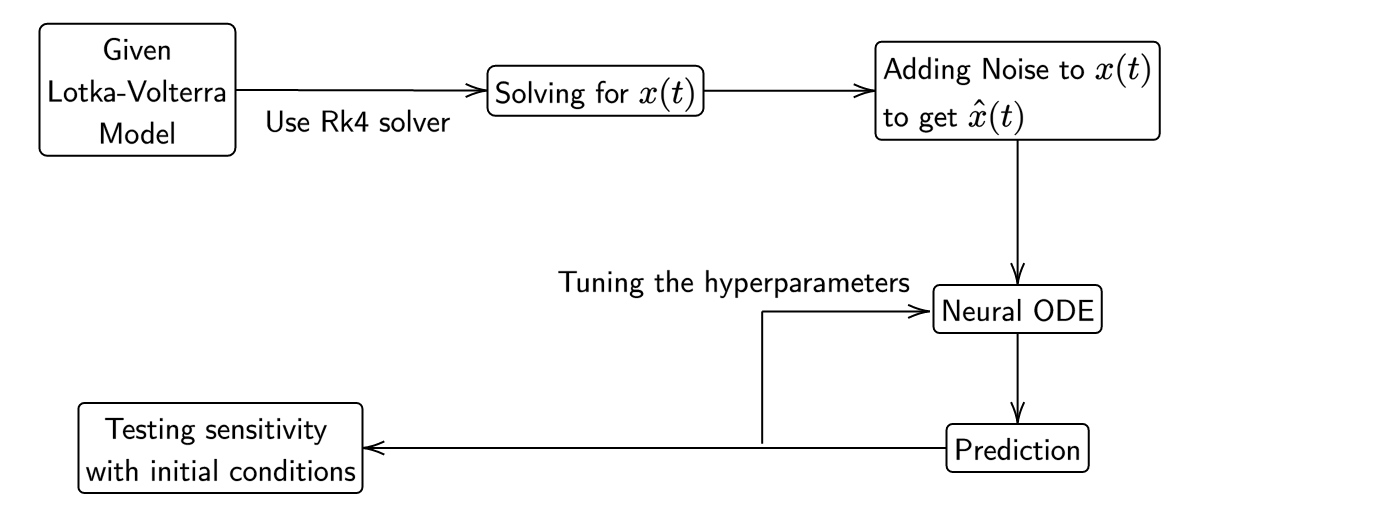

## Introduction
The aim of this project is to use Neural Ordinary Differential Equations (Neural ODE) to learn the unknown dynamics of a system from time series data. 


## Problem Statement

The problem at hand concerns discovering the unknown dynamics of a given dynamical system, represented by the equation $\dot{x} =f(x)$ with a specified initial condition $x(0)=x_{0}$. The data available for analysis is the time series data of $x(t)$ for the aforementioned initial condition $x_{0}$.

To address this problem, we have selected the Lotka-Volterra or Predator-Prey dynamical system, described by the equations:
$$
\begin{align*}
\begin{bmatrix}
\dot{x}_{1}\\
\dot{x}_{2}
\end{bmatrix} & =\begin{bmatrix}
ax_{1} -bx_{1} x_{2}\\
cx_{1} x_{2} -dx_{2}
\end{bmatrix} =f( x) ,\\
\begin{bmatrix}
x_{1}( 0)\\
x_{2}( 0)
\end{bmatrix} & =\begin{bmatrix}
1\\
1
\end{bmatrix} .
\end{align*}
$$
Here, the values of $a,b,c,$ and $d$ are predefined as $1.5,1,1,$ and $0.5$ respectively. However, the governing dynamics function $f(x)$ is unknown.

The objective of this project is to develop a neural network that can approximate $\dot{x}_{1}$ and $\dot{x}_{2}$ from the given time series data of $x_{1} (t)$ and $x_{2} (t)$, thus allowing us to discover the unknown dynamics $f(x)$.



## Method

### 1. Generating Data

#### Importing Necessary modules

In [12]:
%pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

#### Defining ODE Solver

In our study, we employed the RK4 method for numerical integration to obtain the time series data from the given dynamics function. The solution of the initial value problem for $\dot{x} = f(x,\tau)$, with an initial condition of $x(0) = x_{0}$, can be expressed as:

\begin{align*}
x(t) & = x_{0} + \int _{0}^{t} f(x,\tau) d\tau.
\end{align*}

In the RK4 method, the integral $\int _{0}^{t} f(x,\tau) d\tau$ is approximated using the following formula:

\begin{align*}
\int_{0}^{t} f(x) d\tau & \approx \frac{1}{6}[ k_{1} + 2(k_{2} + k_{3}) + k_{4} ] \Delta t, \\
k_{1} & = f(t,x), \\
k_{2} & = f\left(t + \frac{1}{2} \Delta t, x + \frac{\Delta t}{2} k_{1}\right), \\
k_{3} & = f\left(t + \frac{1}{2} \Delta t, x + \frac{\Delta t}{2} k_{2}\right), \\
k_{4} & = f(t + \Delta t, x + \Delta t k_{2}).
\end{align*}

In this approximation, $k_{1}$, $k_{2}$, $k_{3}$, and $k_{4}$ are intermediate values that are computed using the dynamics function $f(x,\tau)$ and the current state of the system $x$ at specific time steps, and $\Delta t$ denotes the time step. The RK4 method is widely used due to its accuracy and ability to handle non-linear systems.

In [14]:
def rk4(func, t, dt, y):
  _one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)
  
  return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth 

In [15]:
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

#### Lotka-Volterra 

In [16]:
# generate toy dataset
data_size = 1000
true_y0 = torch.tensor([[1., 1.]]).cuda()
t = torch.linspace(0., 10., data_size).cuda()


In [17]:
a = 1.5
b = 1
c = 1
d = 0.5
class Lambda(nn.Module):
  def forward(self, t, y):
    y1 = y[0,0]
    y2 = y[0,1]
    return torch.tensor([[a*y1 - b*y1*y2, c*y1*y2- d*y2]]).cuda()

with torch.no_grad():
  node = NeuralODE(func=Lambda()).cuda()
  true_y = node(y0=true_y0, t=t, solver=rk4)


## Adding noise to the data

In [18]:
# specify the standard deviation of the noise
noise_stddev = 0.01

# generate random noise tensor with the same shape as true_y
noise = (torch.randn(true_y.shape) * noise_stddev).cuda()

# add the noise to true_y
noisy_y = true_y + noise


## Visualizing the datasets

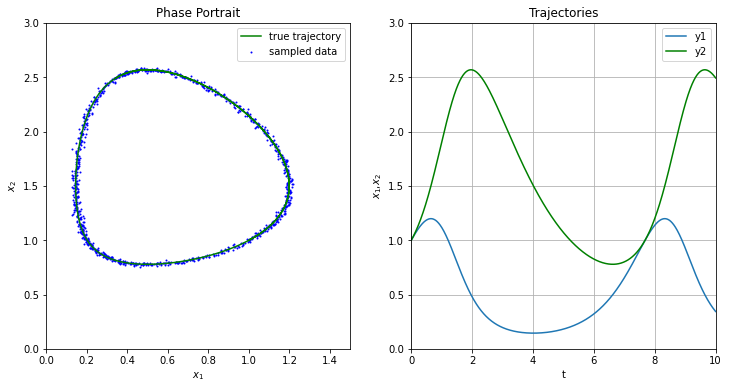

In [19]:
def visualize(true_y, noisy_y, pred_y=None):
  fig = plt.figure(figsize=(12, 6), facecolor='white')
  ax = fig.add_subplot(121)
  ax.set_title('Phase Portrait')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax2 = fig.add_subplot(122)
  ax2.set_title('Trajectories')
  ax2.set_xlabel('t')
  ax2.set_ylabel('$x_1$,$x_2$')

  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
  ax2.legend(['y1','y2'])



  ax.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  ax.scatter(noisy_y.cpu().numpy()[:, 0, 0], noisy_y.cpu().numpy()[
             :, 0, 1], color='blue', label='sampled data', s=1)
  
  if pred_y is not None:
    ax.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'red', label='learned trajectory')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')

  ax.set_xlim(0, 1.5)
  ax.set_ylim(0, 3)

  ax2.set_xlim(t.cpu().min(), t.cpu().max())
  ax2.set_ylim(0, 3)
  ax.legend()
  ax2.grid(True)
  plt.show()

visualize(true_y, noisy_y)

# Training

In [20]:
batch_time = 50
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = noisy_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([noisy_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [21]:
# define dynamic function
class ODEFunc(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 100),
                             nn.Tanh(),
                             nn.Linear(100, 100),
                             nn.Tanh(),
                             nn.Linear(100, 50),
                             nn.Tanh(),
                             nn.Linear(50,2))


  def forward(self, t, y):
    output = self.net(y)
    return output

  0%|          | 0/2001 [00:00<?, ?it/s]

Iter 0000 | Total Loss 1.240347


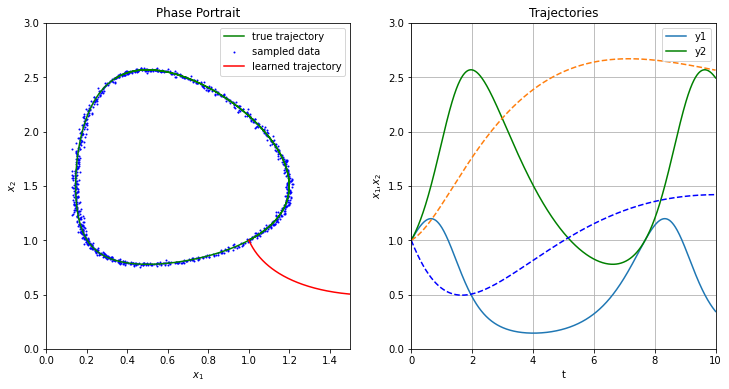

Iter 0200 | Total Loss 0.406097


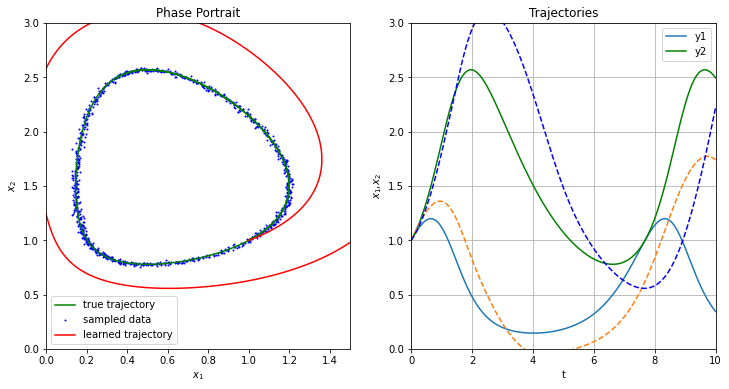

Iter 0400 | Total Loss 0.167296


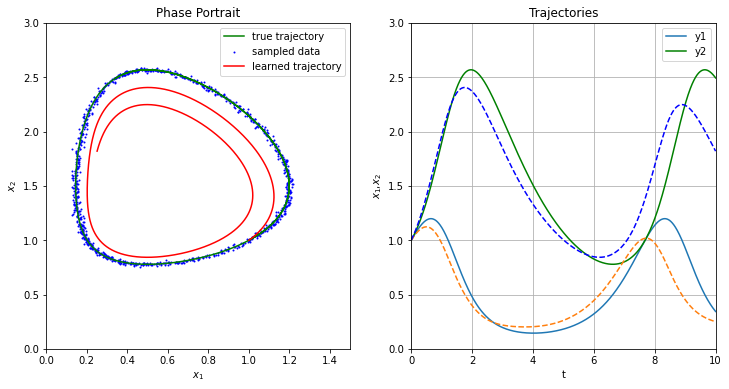

Iter 0600 | Total Loss 0.075596


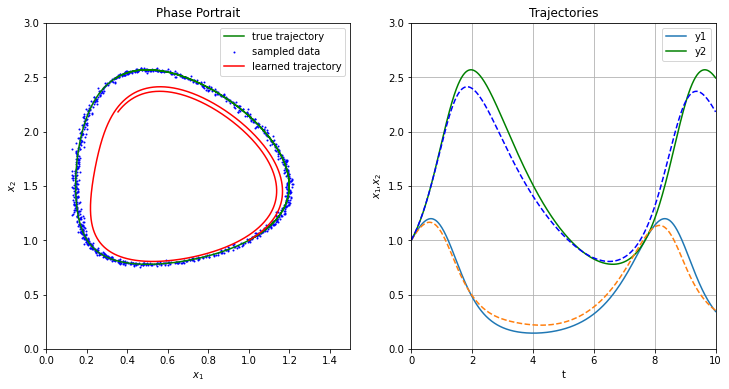

Iter 0800 | Total Loss 0.058320


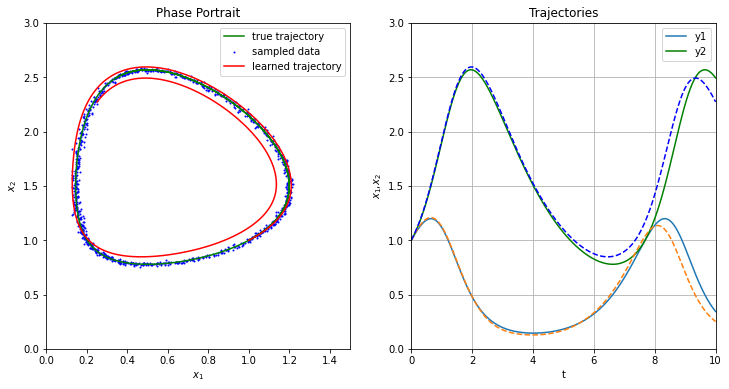

Iter 1000 | Total Loss 0.063837


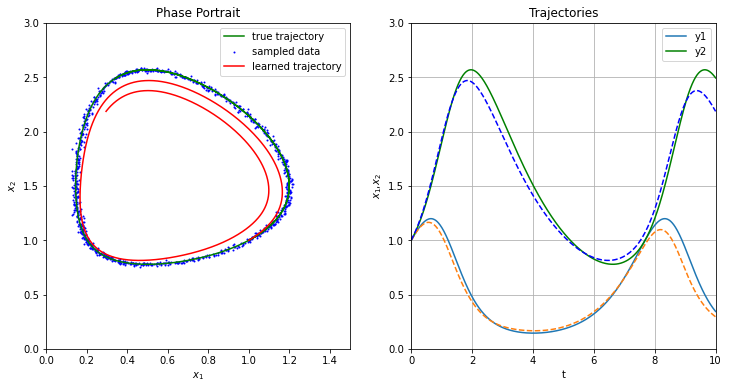

Iter 1200 | Total Loss 0.058318


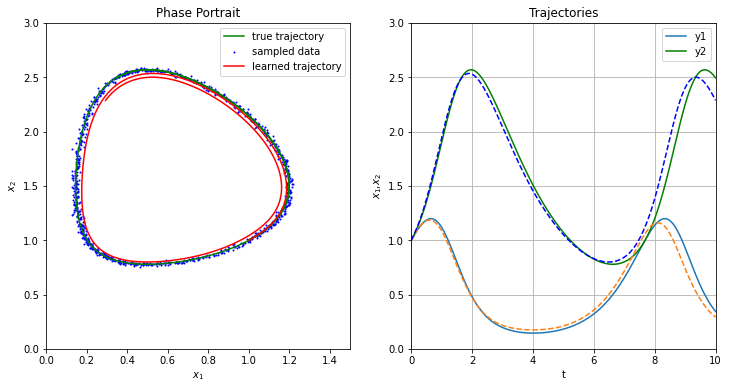

Iter 1400 | Total Loss 0.184228


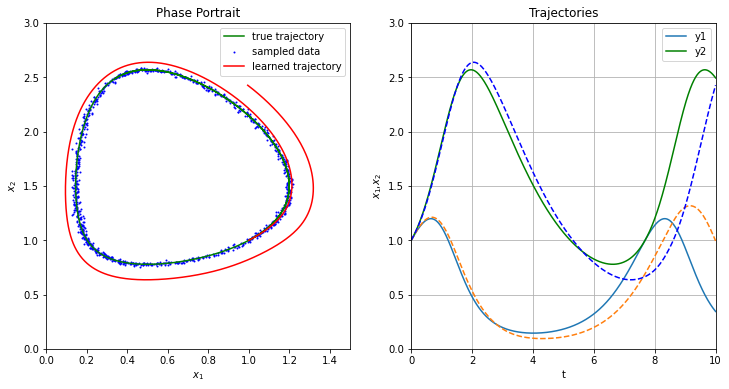

Iter 1600 | Total Loss 0.038028


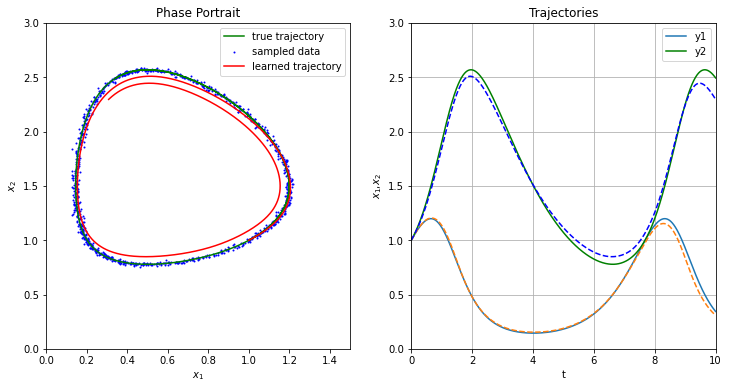

Iter 1800 | Total Loss 0.036417


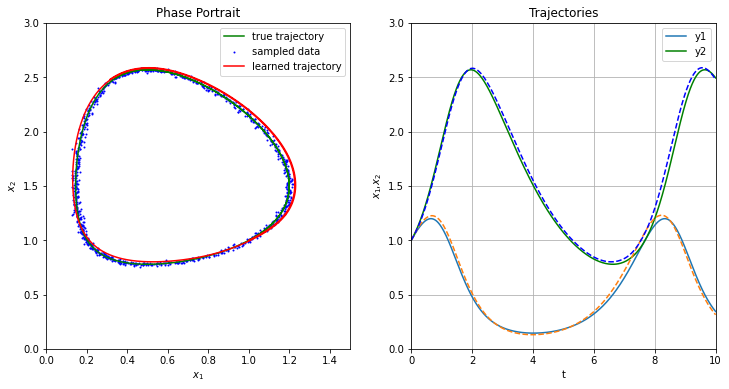

Iter 2000 | Total Loss 0.111499


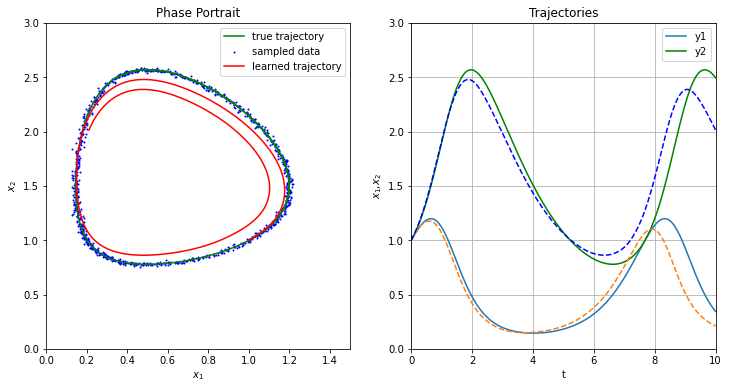

process time: 1926.5779814720154 sec


In [22]:
from torchdiffeq import odeint_adjoint

## Train
niters = 2000

func = ODEFunc().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 200 == 0:
    with torch.no_grad():
      pred_y = odeint_adjoint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      loss = torch.mean(torch.abs(pred_y - noisy_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, noisy_y, pred_y)
      plt.plot(iter, loss.item())

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))
